In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.author_vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_data = pd.read_pickle('../data/04c_Test_Set.pkl')

# Style Embeddings from Style Model

In [3]:
model = StyleModel()
model.load_state_dict(torch.load('../model/TestData_StyleModel.pt'))

<All keys matched successfully>

In [4]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 10684/10684 [04:12<00:00, 42.38it/s]


## Centroids

In [5]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [6]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6
0,0.000,1.860,1.847,1.940,1.878,1.952,1.936
1,0.000,0.000,0.285,0.516,0.285,0.374,0.305
2,0.000,0.000,0.000,0.505,0.181,0.259,0.228
3,0.000,0.000,0.000,0.000,0.512,0.554,0.503
4,0.000,0.000,0.000,0.000,0.000,0.281,0.208
5,0.000,0.000,0.000,0.000,0.000,0.000,0.192
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

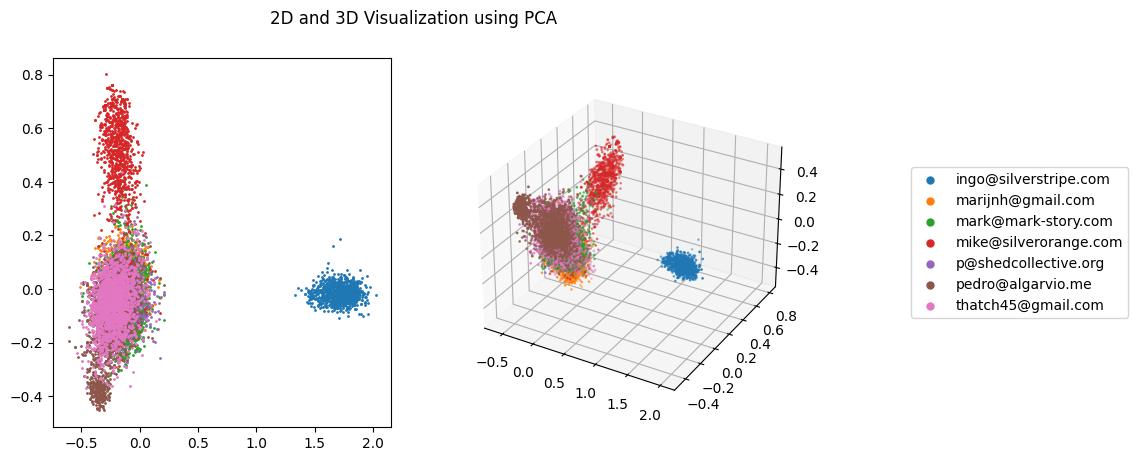

In [7]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

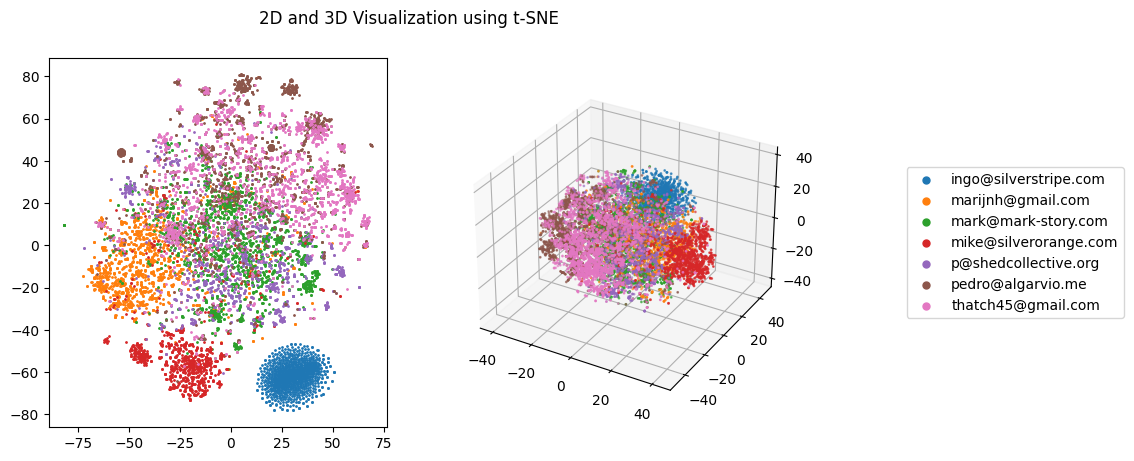

In [8]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 3
10 Most common:
[(1, 5907), (-1, 3771), (0, 1006)]


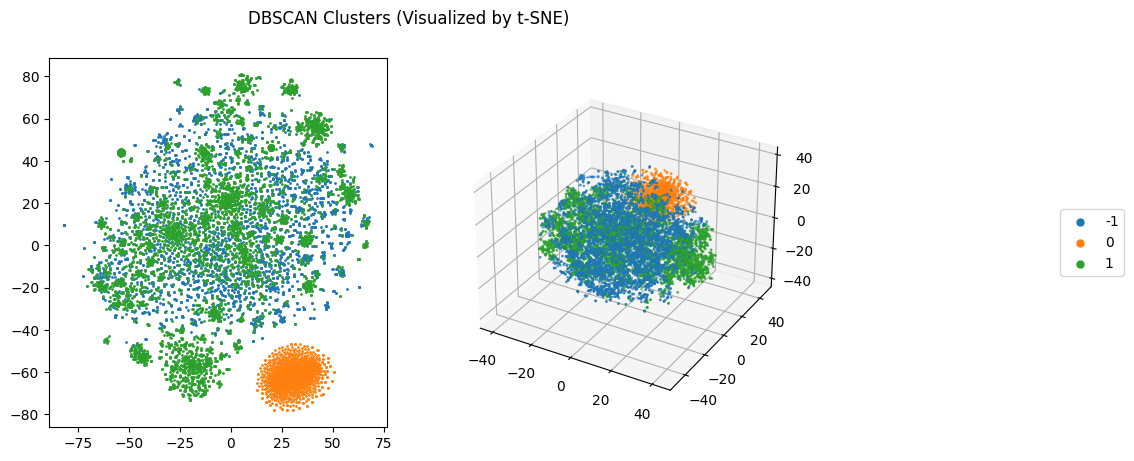

In [9]:
dbscan_model = DBSCAN(eps=1, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [10]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,3771.0,6.0,624.5,"('thatch45@gmail.com', 1051)",56.0,7.5,"('saltstack_salt', 1572)"
1,1006.0,1.0,1006.0,"('ingo@silverstripe.com', 1006)",29.0,4.0,"('silverstripe_silverstripe-framework', 605)"
2,5907.0,6.0,964.0,"('mark@mark-story.com', 1417)",56.0,6.0,"('saltstack_salt', 2226)"


In [11]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,3561.333333,4.333333,864.833333,47.000000,5.833333
std,2457.218007,2.886751,209.191499,15.588457,1.755942
min,1006.000000,1.000000,624.500000,29.000000,4.000000
25%,2388.500000,3.500000,794.250000,42.500000,5.000000
50%,3771.000000,6.000000,964.000000,56.000000,6.000000
75%,4839.000000,6.000000,985.000000,56.000000,6.750000
max,5907.000000,6.000000,1006.000000,56.000000,7.500000


In [12]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0,1,2
length_mean,68.843012,148.681909,68.787202
length_std,50.537622,87.788820,45.826111
n_uppercase_mean,2.569345,12.356859,2.844760
n_uppercase_std,2.930043,6.448672,2.768558
polarity_mean,0.018534,0.026102,0.006403
polarity_std,0.181699,0.159979,0.180823
subjectivity_mean,0.192168,0.288391,0.174805
subjectivity_std,0.286359,0.245339,0.281642


In [13]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
Take inclusiveLeft/Right into account when preventing editing of readOnly spans
___
2) 
Another refinement to Rhino-detection

Issue #<I>
___
3) 
prevent line numbers from confusing click-position-detection
___
4) 
[stex mode] Reposition some else lines to match coding style
___
5) 
Properly export rebaseSteps from collab module
___
6) 
Allow directly passing nodes and styles to Schema constructor
___
7) 
[rust mode] Fix problem with parsing of alt
___
8) 
Hack to work around Safari crash on setDragImage

Closes #<I>
___
9) 
Define replaceSelection in a simpler way by using new empty node rules
___
10) 
Make Chinese and Japanese characters count as word characters
_________________

Number of messages in this class: 3771
Most common author:
('thatch45@gmail.com', 1051)
Most common project:
('saltstack_salt', 1572)



________________ Class 1 ________________

___
1) 
API CHANGE Removed Member::init_db_fields(), its no longer needed du

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 7
10 Most common:
[(3, 3070), (0, 2444), (2, 1864), (1, 1006), (4, 924), (6, 872), (5, 504)]


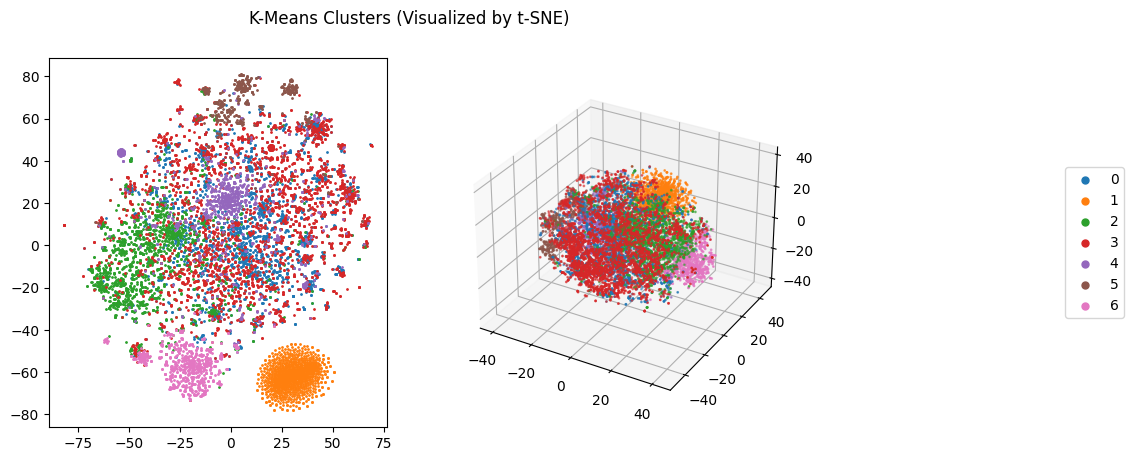

In [14]:
kmeans = KMeans(7)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [15]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,2444.0,6.0,440.5,"('mark@mark-story.com', 889)",50.0,5.0,"('saltstack_salt', 915)"
1,1006.0,1.0,1006.0,"('ingo@silverstripe.com', 1006)",29.0,4.0,"('silverstripe_silverstripe-framework', 605)"
2,1864.0,6.0,170.5,"('marijnh@gmail.com', 1054)",40.0,3.0,"('codemirror_CodeMirror', 831)"
3,3070.0,6.0,505.0,"('thatch45@gmail.com', 1092)",53.0,5.0,"('saltstack_salt', 1688)"
4,924.0,6.0,85.5,"('mark@mark-story.com', 462)",22.0,3.0,"('cakephp_cakephp', 449)"
5,504.0,4.0,53.0,"('pedro@algarvio.me', 397)",7.0,3.0,"('saltstack_salt', 489)"
6,872.0,5.0,5.0,"('mike@silverorange.com', 845)",5.0,8.0,"('silverorange_swat', 845)"


In [16]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1526.285714,4.857143,323.642857,29.428571,4.428571
std,952.707320,1.864454,357.561849,19.346465,1.812654
min,504.000000,1.000000,5.000000,5.000000,3.000000
25%,898.000000,4.500000,69.250000,14.500000,3.000000
50%,1006.000000,6.000000,170.500000,29.000000,4.000000
75%,2154.000000,6.000000,472.750000,45.000000,5.000000
max,3070.000000,6.000000,1006.000000,53.000000,8.000000


In [17]:
clustering_spacy_evaluation(kmeans_prediction, test_data)

,0,1,2,3,4,5,6
length_mean,77.610065,148.681909,77.553112,62.372638,68.417749,51.839286,58.332569
length_std,57.226992,87.788820,48.721579,46.222996,42.506312,21.462406,22.632625
n_uppercase_mean,3.219313,12.356859,3.314378,2.083388,2.914502,1.924603,2.738532
n_uppercase_std,3.552301,6.448672,2.659078,2.579590,2.637608,1.422003,1.875232
polarity_mean,-0.003679,0.026102,0.012825,0.024613,-0.014072,0.009763,0.029040
polarity_std,0.194101,0.159979,0.191941,0.172021,0.186632,0.116398,0.170675
subjectivity_mean,0.193247,0.288391,0.212210,0.182042,0.166725,0.076066,0.158397
subjectivity_std,0.284314,0.245339,0.293004,0.290166,0.259641,0.201967,0.285737


In [18]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
Properly export rebaseSteps from collab module
___
2) 
Fix reload-while-focused corruption problem in IE9
___
3) 
Fix adjacency check in undo event aggregation

It was sometimes treating non-adjacent changes as adjacent,
and corrupted the undo history with bogus data.

Issue #<I> (part 1)
___
4) 
[gherkin mode] Remove double mime definition
___
5) 
Fix initialization of IsCallee and HasMethodCall constraints

They were not getting a proper origin, causing them to be accidentally
purged at the wrong time.
___
6) 
[demo] Destroy server when switching projects

Issue #<I>
___
7) 
Fix the way updateAttrs overwrites the member property
___
8) 
[lint addons] Don't error on missing dependencies

Closes #<I>
___
9) 
[show-hint addon] Fix accidentally renamed option
___
10) 
[requirejs plugin] Don't get confused by base paths starting with /

Issue #<I>
_________________

Number of messages in this class: 2444
Most common author:
('mark@mark-s